# Trajectory-wise analyses

In this tutorial, we will use trajectory wise analysis to expore regulatory mechanisms of hematopoiesis.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns

# filter warnings for cleaner tutorials
import warnings
warnings.filterwarnings('ignore')

dyn.dynamo_logger.main_silence()
dyn.configuration.set_figure_params('dynamo', background='white')

In [2]:
adata_labeling = dyn.sample_data.hematopoiesis()

take a glance at what is in `adata` object. All observations, embedding layers and other data in `adata` are computed within `dynamo`. Please refer to other dynamo tutorials regarding how to obtain these values from metadata and raw new/total and (or) raw spliced/unspliced gene expression values.

In [3]:
adata_labeling

AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


[<Axes: title={'center': 'cell_type'}>]

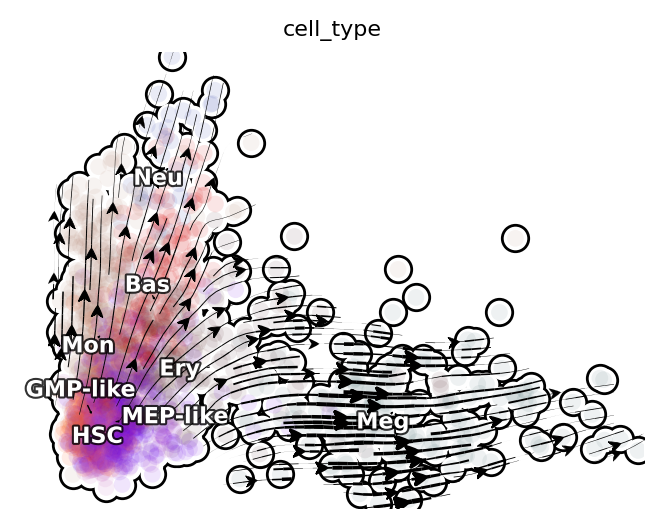

In [4]:
pca_dim = [0, 1]
dyn.pl.streamline_plot(
    adata_labeling,
    color="cell_type",
    use_smoothed=False,
    cmap="bwr",
    basis="pca",
    sym_c=True,
    x=pca_dim[0],
    y=pca_dim[1],
    frontier=True,
    sort="abs",
    alpha=0.2,
    pointsize=0.1,
    despline=True,
    despline_sides=["right", "top"],
    deaxis=False,
    save_show_or_return="return",
    s_kwargs_dict={'adjust_legend':True},
    figsize=(4,3)
    
)


In [5]:
HSC_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "HSC")
Meg_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Meg")
Ery_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Ery")
Bas_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Bas")
Mon_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Mon")
Neu_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Neu")


In [8]:
# dyn.pd.fate(adata_labeling, init_cells=adata_labeling.obs_names[Mon_cells[0]], basis='pca', direction='backward', interpolation_num=500)
_=dyn.pd.fate(
    adata_labeling,
    init_cells=adata_labeling.obs_names[Meg_cells[0]],
    basis="pca",
    direction="backward",
    interpolation_num=500,
)


uniformly sampling points along a trajectory: 100%|██████████| 1/1 [00:00<00:00, 194.00it/s]


In [9]:
_=dyn.pd.fate(
    adata_labeling,
    # init_cells=adata_labeling.obs_names[Meg_cells[0]],
    init_cells=adata_labeling.obs_names[Meg_cells[2]],
    basis="pca",
    direction="backward",
    interpolation_num=500,
)


uniformly sampling points along a trajectory: 100%|██████████| 1/1 [00:00<00:00, 186.90it/s]


In [10]:
adata_labeling.uns["fate_pca"].keys()


dict_keys(['init_states', 'init_cells', 'average', 't', 'prediction', 'genes'])

In [11]:
adata_labeling.uns["fate_pca"]["prediction"][0].shape, len(
    adata_labeling.uns["fate_pca"]["t"][0],
)

((30, 500), 500)

In [12]:
from anndata import AnnData
from scipy.sparse import csr_matrix
from dynamo.vectorfield.utils import vector_transformation


path_id = 0
dyn.tools.utils.nearest_neighbors(
    adata_labeling.uns["fate_pca"]["prediction"][path_id].T[0, :], adata_labeling.obsm["X_pca"], 5
)[0][1]

dyn.tools.utils.nearest_neighbors(
    adata_labeling.uns["fate_pca"]["prediction"][path_id].T[140, :], adata_labeling.obsm["X_pca"], 5
)


vec_dict, vecfld = dyn.vf.utils.vecfld_from_adata(adata_labeling, basis="pca")


vector_field_class = dyn.vf.SvcVectorField()
vector_field_class.from_adata(adata_labeling, basis="pca")

X_data = adata_labeling.uns["fate_pca"]["prediction"][path_id].T[:140, :]
vel_norm = vector_field_class.func(X_data)
acc_norm, acc_mat = vector_field_class.compute_acceleration(X=X_data)
curv_norm, curv_mat = vector_field_class.compute_curvature(X=X_data)
div = vector_field_class.compute_divergence(X=X_data)

Jac_func = vector_field_class.get_Jacobian()
Js = Jac_func(X_data)

X_data.shape, Js.shape, adata_labeling.uns["fate_pca"]["prediction"][path_id].T.shape
adata_labeling.uns["PCs"].shape, adata_labeling.uns["pca_mean"].shape
Jacobian = dyn.vf.utils.subset_jacobian_transformation(Js, adata_labeling.uns["PCs"], adata_labeling.uns["PCs"])


|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0644s]
|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0684s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.0359s]


Transforming subset Jacobian: 100%|██████████| 140/140 [00:06<00:00, 21.05it/s]


In [14]:
# project the expression state back to higher dimension
exprs = dyn.utils.pca_to_expr(X_data, adata_labeling.uns["PCs"], mean=adata_labeling.uns["pca_mean"])
exprs.shape

(140, 1956)

In [15]:
trajectory_adata = AnnData(
    X=exprs, layers={"M_t": csr_matrix(exprs)}, var=adata_labeling[:, adata_labeling.var.use_for_pca].var
)

trajectory_adata.layers["velocity"] = csr_matrix(vector_transformation(vel_norm, adata_labeling.uns["PCs"]))
trajectory_adata.layers["acceleration"] = vector_transformation(acc_mat, adata_labeling.uns["PCs"])
trajectory_adata.layers["curvature"] = vector_transformation(curv_mat, adata_labeling.uns["PCs"])

adata_labeling.uns["jacobian_pca"].keys(), X_data.shape[0]
trajectory_adata.uns["jacobian_pca"] = {
    "cell_idx": np.arange(X_data.shape[0]),
    "effectors": trajectory_adata.var_names,
    "jacobian": Js,
    "jacobian_gene": Jacobian,
    "regulators": trajectory_adata.var_names,
}


In [16]:
trajectory_adata.obs["integral_time"] = adata_labeling.uns["fate_pca"]["t"][path_id][: X_data.shape[0]]


In [17]:
dyn.pp.recipe_monocle(trajectory_adata)

|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...
|-----> 140 cells passed basic filters.
|-----> filtering gene...
|-----> 32 genes passed basic filters.
|-----> calculating size factor...
|-----? only 32 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
|-----> selecting genes in layer: X, sort method: SVR...
|-----> applying PCA ...
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need 

In [18]:
trajectory_adata.var_names

Index(['FUCA2', 'HECW1', 'MAD1L1', 'CFLAR', 'SARM1', 'CAMKK1', 'ARHGAP33',
       'SLC4A1', 'MPO', 'ITGA3',
       ...
       'AC020651.2', 'AL355999.1', 'AC016168.4', 'AL353576.1', 'AP000926.2',
       'AC108519.1', 'AC004470.2', 'DUS4L-BCAP29', 'AL592295.6', 'AL353671.1'],
      dtype='object', length=1956)

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> [UMAP] completed [4.8943s]


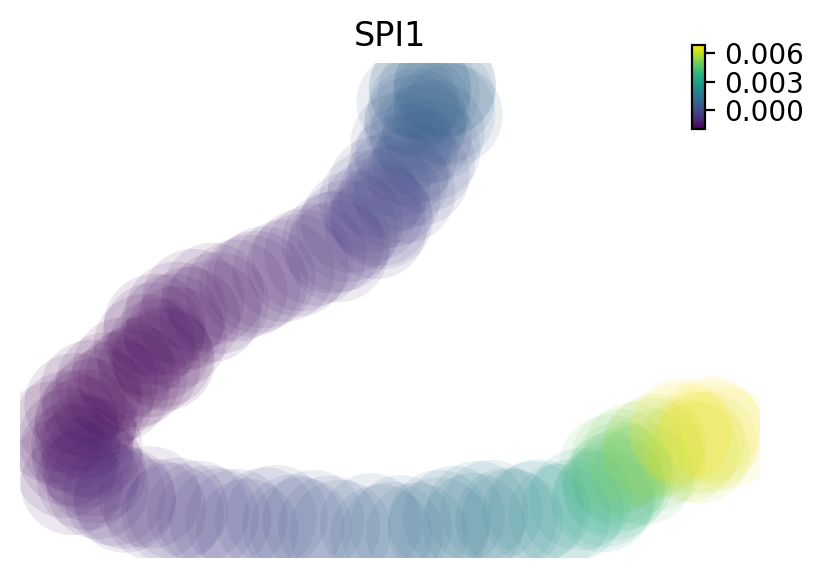

In [19]:
dyn.tl.reduceDimension(trajectory_adata)
dyn.pl.umap(trajectory_adata, color="SPI1",figsize=(4,3))

In [24]:
acceleration[:, 0].shape

(140,)

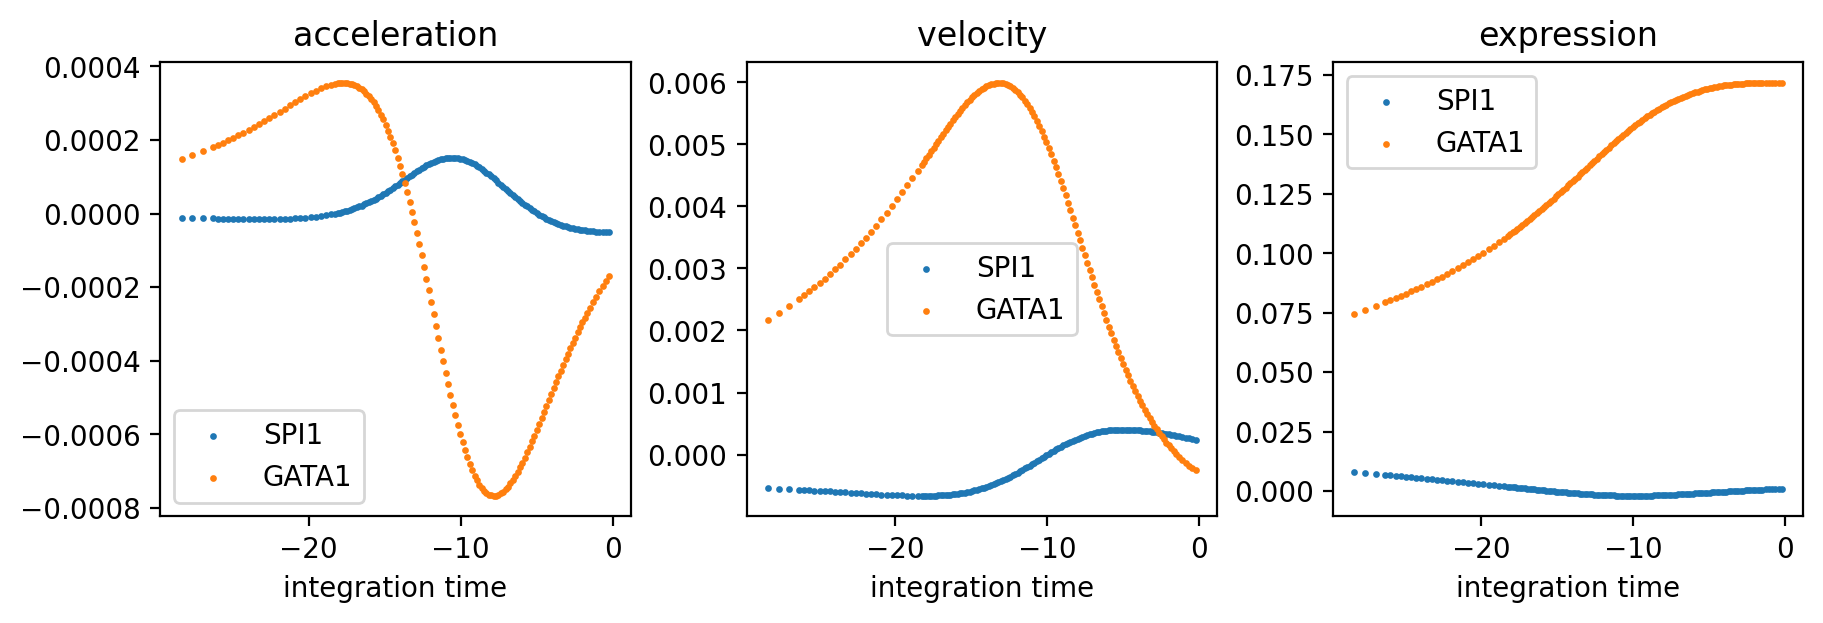

In [32]:
genes = ["SPI1", "GATA1"]
integral_time = trajectory_adata.obs.integral_time[::-1]
expression = trajectory_adata[:, genes].layers["M_t"].A[::-1, :]
velocity = trajectory_adata[:, genes].layers["velocity"].A[::-1, :]
acceleration = trajectory_adata[:, genes].layers["acceleration"].A[::-1, :]

fig1, f1_axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(9, 3))
f1_axes[0].scatter(integral_time, acceleration[:, 0], s=2,  ec=None, label="SPI1")
f1_axes[0].scatter(integral_time, acceleration[:, 1], s=2,  ec=None, label="GATA1")
f1_axes[0].set_title("acceleration")
f1_axes[0].set_xlabel("integration time")
f1_axes[1].scatter(integral_time, velocity[:, 0], s=2, ec=None, label="SPI1")
f1_axes[1].scatter(integral_time, velocity[:, 1], s=2,  ec=None, label="GATA1")
f1_axes[1].set_title("velocity")
f1_axes[1].set_xlabel("integration time")
f1_axes[2].scatter(integral_time, expression[:, 0], s=2, ec=None, label="SPI1")
f1_axes[2].scatter(integral_time, expression[:, 1], s=2, ec=None, label="GATA1")
f1_axes[2].set_title("expression")
f1_axes[2].set_xlabel("integration time")
for ax in f1_axes:
    ax.legend()
fig1

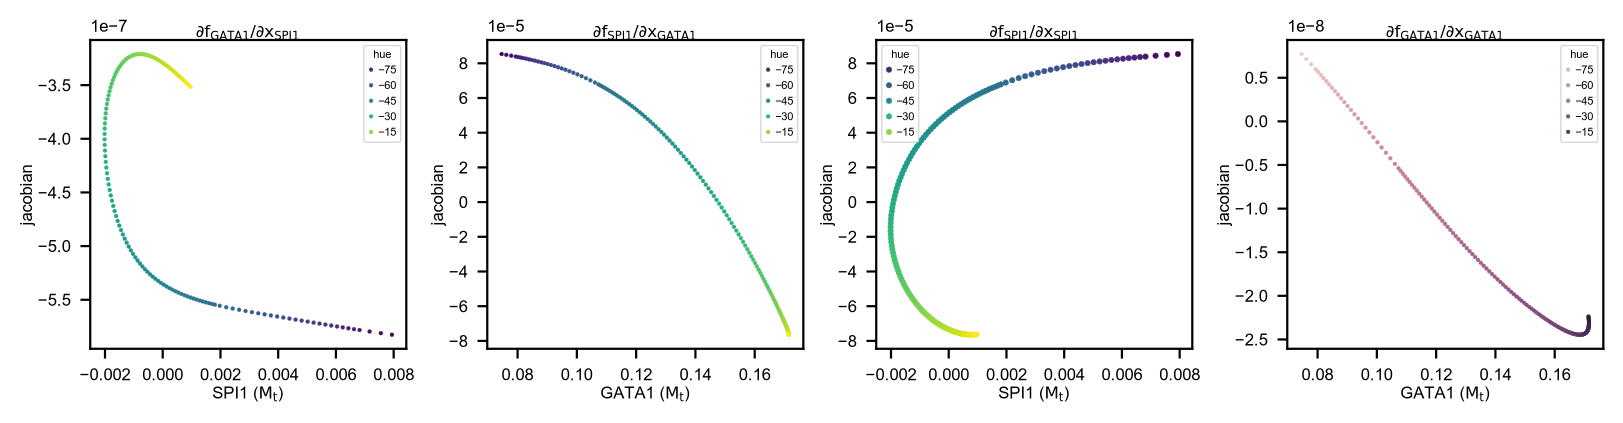

In [82]:
dyn.configuration.set_pub_style()
regulators, effectors = list(adata_labeling.uns["jacobian_pca"]["regulators"]), list(
    adata_labeling.uns["jacobian_pca"]["effectors"]
)
spi1_ind, gata1_ind = regulators.index("SPI1"), effectors.index("GATA1")
fig1, f1_axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(8, 2))
expression = trajectory_adata[:, ["SPI1", "GATA1"]].layers["M_t"].A[::-1, :]

plot_df=pd.DataFrame()
plot_df['expression']=expression[:, 0]
plot_df['jacobian']=Jacobian[gata1_ind, spi1_ind, ::-1]
plot_df['hue']=integral_time.values * 3
sns.scatterplot(
    data=plot_df,
    x='expression',
    y='jacobian',
    hue='hue',
    palette="viridis",
    ax=f1_axes[0],
    ec=None,
    s=2,
)
f1_axes[0].set_title(r"$\partial f_{GATA1}/\partial x_{SPI1}$")
f1_axes[0].set_xlabel(r"SPI1 ($M_t$)")

plot_df=pd.DataFrame()
plot_df['expression']=expression[:, 1]
plot_df['jacobian']=Jacobian[spi1_ind, spi1_ind, ::-1]
plot_df['hue']=integral_time.values * 3
sns.scatterplot(
    data=plot_df,
    x='expression',
    y='jacobian',
    hue='hue',
    palette="viridis",
    ax=f1_axes[1],
    ec=None,
    s=2,
)
f1_axes[1].set_title(r"$\partial f_{SPI1}/\partial x_{GATA1}$")
f1_axes[1].set_xlabel(r"GATA1 ($M_t$)")

plot_df=pd.DataFrame()
plot_df['expression']=expression[:, 0]
plot_df['jacobian']=Jacobian[spi1_ind, spi1_ind, ::-1]
plot_df['hue']=integral_time.values * 3
sns.scatterplot(
    data=plot_df,
    x='expression',
    y='jacobian',
    hue='hue',
    palette="viridis",
    ax=f1_axes[2],
    ec=None,
    s=4,
)
f1_axes[2].set_title(r"$\partial f_{SPI1}/\partial x_{SPI1}$")
f1_axes[2].set_xlabel(r"SPI1 ($M_t$)")

plot_df=pd.DataFrame()
plot_df['expression']=expression[:, 1]
plot_df['jacobian']=Jacobian[gata1_ind, gata1_ind, ::-1]
plot_df['hue']=integral_time.values * 3
sns.scatterplot(
    data=plot_df,
    x='expression',
    y='jacobian',
    hue='hue',
    ax=f1_axes[3],
    ec=None,
    s=2,
)
f1_axes[3].set_title(r"$\partial f_{GATA1}/\partial x_{GATA1}$")
f1_axes[3].set_xlabel(r"GATA1 ($M_t$)")
fig1

In [57]:
import matplotlib as mpl
dyn.configuration.set_pub_style(scaler=2)
res=dyn.pl.response(
    adata_labeling,
    np.array([["SPI1", "SPI1"], ["SPI1", "GATA1"], 
              ["GATA1", "SPI1"], ["GATA1", "GATA1"]]),
    xkey='X_total',
    ykey="velocity_alpha_minus_gamma_s",
    log=False,
    drop_zero_cells=False,
    grid_num=20,
    return_data=True,
)


In [58]:
res[0].head()

,x,y,den,type
"(0,)",0.0,-0.046788,0.001001,SPI1->SPI1
"(1,)",0.0,-0.029499,0.003225,SPI1->SPI1
"(2,)",0.0,-0.012210,0.175957,SPI1->SPI1
"(3,)",0.0,0.005078,1.000000,SPI1->SPI1
"(4,)",0.0,0.022367,0.549937,SPI1->SPI1


In [59]:
res[1].head()

,x,y,den,type
"(1200,)",0.0,-0.045187,0.001488,GATA1->GATA1
"(1201,)",0.0,-0.029952,0.008497,GATA1->GATA1
"(1202,)",0.0,-0.014718,0.034737,GATA1->GATA1
"(1203,)",0.0,0.000517,1.000000,GATA1->GATA1
"(1204,)",0.0,0.015751,0.280479,GATA1->GATA1
